In [31]:
import pandas as pd
import numpy as np
import os
import warnings
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [32]:
current_directory = os.getcwd()
current_directory

'/Users/ruijuewang/Desktop/DFT/Sem2/FT5005 ML for Finance/Group Project/github/FT5005-Group6/Cleaned Data'

## EBITDA - LSTM Model

In [33]:
processed_df = pd.read_csv('EBITDA_new.csv')

In [34]:
processed_df['EBITDA_lag2'] = processed_df.groupby('ticker')['EBITDA'].shift(2)

# processed_df['salePrice_lag1'] = processed_df.groupby('ticker')['salePrice'].shift(1)
# processed_df['realGDPSA_lag1'] = processed_df.groupby('ticker')['realGDPSA'].shift(1)
# processed_df['m2SA_lag1'] = processed_df.groupby('ticker')['m2SA'].shift(1)
# processed_df['m2MinusM1SA_lag1'] = processed_df.groupby('ticker')['m2MinusM1SA'].shift(1)
# processed_df['m2Velocity_lag1'] = processed_df.groupby('ticker')['m2Velocity'].shift(1)
# processed_df['primeRate_lag1'] = processed_df.groupby('ticker')['primeRate'].shift(1)

# processed_df['EBITDA_diff'] = processed_df.groupby('ticker')['EBITDA'].pct_change()
# processed_df['salePrice_diff'] = processed_df.groupby('ticker')['salePrice'].pct_change()
# processed_df['realGDPSA_diff'] = processed_df.groupby('ticker')['realGDPSA'].pct_change()
# processed_df['m2SA_diff'] = processed_df.groupby('ticker')['m2SA'].pct_change()
# processed_df['m2MinusM1SA_diff'] = processed_df.groupby('ticker')['m2MinusM1SA'].pct_change()
# processed_df['m2Velocity_diff'] = processed_df.groupby('ticker')['m2Velocity'].pct_change()
# processed_df['primeRate_diff'] = processed_df.groupby('ticker')['primeRate'].pct_change()

In [35]:
# Select features and target variable
features = ['capitalExpenditure_', 'netIncome_', 'operatingIncome_', 'shareholdersEquity_', 
            'totalAssets_', 'EPS_', 'debtToTotalAssets', 'niToAsset', 'ROA', 'revenueGrowth', 
            'quickRatio', 'rsi', 'mva', 'cfroi', 'salePrice', 'realGDPSA', 'm2SA', 
            'm2MinusM1SA', 'm2Velocity', 'primeRate','EBITDA_lag1', 'EBITDA_lag2']
target = 'EBITDA'

# Remove missing values
processed_df = processed_df.dropna(subset=features + [target])
processed_df.replace([np.inf, -np.inf], np.nan, inplace=True)
processed_df.dropna(inplace=True)

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [37]:
# Split the dataset
X = processed_df[features]
y = processed_df[target].values.reshape(-1, 1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)


In [38]:
# Convert to supervised learning format
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

In [39]:
# Create sequences
seq_length = 10
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

# Split data
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print(f'X_train shape: {X_train.shape}') 
print(f'y_train shape: {y_train.shape}')

X_train shape: (181, 10, 22)
y_train shape: (181, 1)


In [40]:
import tensorflow.keras.backend as K
import tensorflow as tf

def r2_keras(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

In [63]:
# Build model

import tensorflow as tf
import random

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds(42)

# model = Sequential([
#     LSTM(30, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
#     Dropout(0.1),
#     LSTM(30, activation='tanh'),
#     Dropout(0.1),
#     Dense(1)
# ])

model = Sequential([
    LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(1)
]) 
# early stop: (30) with seq=10, batch 40 => Test MSE: 2.2742, Test R2: 0.3407, but train is very poor
# without early stop: (30) with seq=10, Dropout(0.1), batch_size=40 => Test MSE: 2.7935, Test R2: 0.1901, Train MSE: 2.2511, Train R2: 0.3331

model.compile(optimizer='adam', loss='mse')
# model.compile(optimizer='adam', loss='mse', metrics=[r2_keras])

X_val = X_test.copy()
y_val = y_test.copy()

# early_stop = EarlyStopping(
#     monitor='val_loss',      # What to monitor
#     patience=10,             # Number of epochs to wait for improvement
#     restore_best_weights=True,  # Roll back to best weights
#     verbose=1                # Prints when it stops early
# )

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=30,
#     batch_size=40,
#     callbacks=[early_stop],
#     verbose=1
# )


history = model.fit(X_train, y_train, epochs=20, batch_size=40, validation_data=(X_val, y_val))

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.3948 - val_loss: 0.1556
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1108 - val_loss: 0.0765
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1230 - val_loss: 0.0806
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1246 - val_loss: 0.0677
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0788 - val_loss: 0.0825
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1025 - val_loss: 0.0955
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0950 - val_loss: 0.0838
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0698 - val_loss: 0.0684
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0701 - val_loss: 0.0612
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0735 - val_loss: 0.0605
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0684 - val_loss: 0.0616
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0675 - val_loss: 0.0637


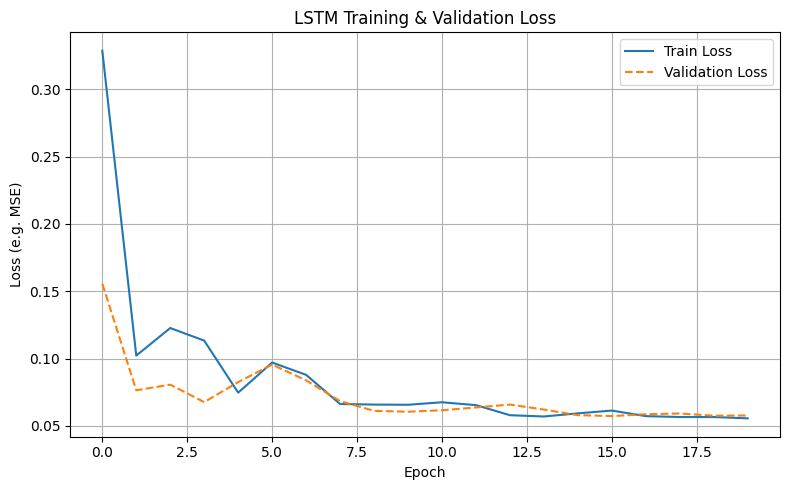

In [64]:
import matplotlib.pyplot as plt

# 画 Loss 曲线
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('LSTM Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (e.g. MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [65]:
# plt.figure(figsize=(8, 5))
# plt.plot(history.history['r2_keras'], label='Train R2')
# plt.plot(history.history['val_r2_keras'], label='Validation R2', linestyle='--')
# plt.title('LSTM Training & Validation R2')
# plt.xlabel('Epoch')
# plt.ylabel('R2')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Train MSE: 1.8233
Train R2: 0.4557


Text(0.5, 1.0, 'Train Prediction vs Ground Truth')

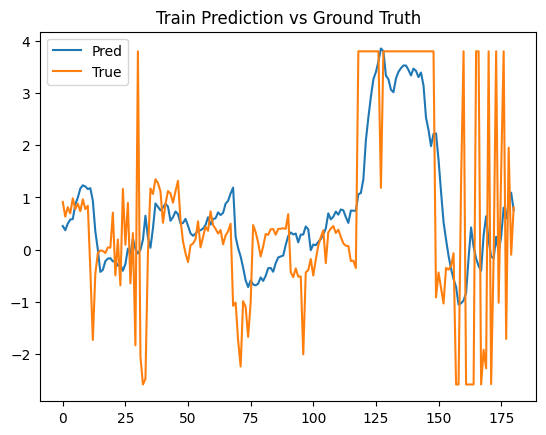

In [66]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_train)
y_train_inv = scaler_y.inverse_transform(y_train)
y_pred_inv = scaler_y.inverse_transform(y_pred)

mse = mean_squared_error(y_train_inv, y_pred_inv)
r2 = r2_score(y_train_inv, y_pred_inv)
print(f"Train MSE: {mse:.4f}")
print(f"Train R2: {r2:.4f}")

plt.plot(y_pred_inv, label='Pred')
plt.plot(y_train_inv, label='True')
plt.legend()
plt.title("Train Prediction vs Ground Truth")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Test MSE: 2.3480
Test R2: 0.3178


Text(0.5, 1.0, 'Test Prediction vs Ground Truth')

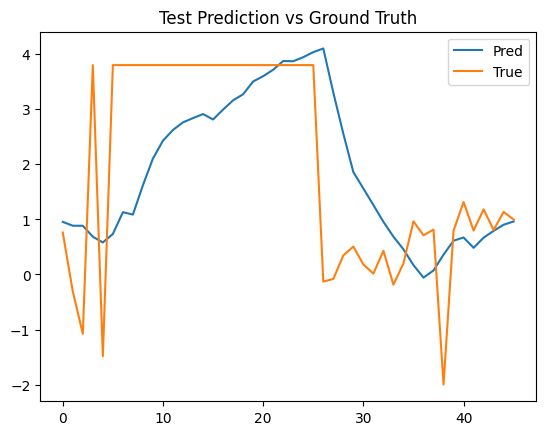

In [67]:
# Predict and evaluate
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"Test MSE: {mse:.4f}")
print(f"Test R2: {r2:.4f}")

plt.plot(y_pred_inv, label='Pred')
plt.plot(y_test_inv, label='True')
plt.legend()
plt.title("Test Prediction vs Ground Truth")